In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control as ct
import lmfit
from pytz import timezone
import vaex
import pvlib

import sys
sys.path.append('../../../')

from utils.plot import config_matplotlib, figsize, fig_save_and_show
from utils.optimization import MyOptimizationProblem, convert_to_model_params, plot_optimization_params, plot_optimization_error, plot_compare
from utils.data import get_events, load_df as load_df_inner

config_matplotlib()
latex_img_path = '/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/'

# Data

In [12]:
events, tzinfo = get_events()
events

,start,end
name,,
01.Curta,2020-01-29 13:51:59-03:00,2020-01-29 14:20:25-03:00
02.Longa,2020-01-30 11:16:45-03:00,2020-01-30 14:55:30-03:00
03.Revezamento,2020-01-31 11:23:23-03:00,2020-01-31 12:27:23-03:00
04.Curta,2020-02-01 10:15:15-03:00,2020-02-01 11:37:28-03:00
05.Curta,2020-02-01 13:15:09-03:00,2020-02-01 13:32:55-03:00
07.Sprint,2020-02-02 11:58:27-03:00,2020-02-02 11:59:09-03:00


original columns: Index(['Battery Pack Voltage (MCS)', 'Battery 1 Pack Voltage (MCB)',
       'Battery 2 Pack Voltage (MCB)', 'Battery 1 Pack Voltage (MCC)',
       'Battery 2 Pack Voltage (MCC)', 'Battery 3 Pack Voltage (MCC)',
       'Battery 1 Cell Voltage (MSC)', 'Battery 2 Cell Voltage (MSC)',
       'Battery 3 Cell Voltage (MSC)', 'Battery Input Current Sensor State',
       'Battery Input Current', 'Battery Output Current Sensor State',
       'Battery Output Current', 'ESC State', 'ESC Duty Cycle (MAM)',
       'ESC Duty Cycle (MSWI)', 'ESC Motor On (MSWI)', 'ESC Boat On (MSWI)',
       'ESC Duty Cycle (MIC)', 'ESC Motor On (MIC)', 'ESC Boat On (MIC)',
       'Motor Angular Speed', 'MPPT 1 Input Voltage', 'MPPT 2 Input Voltage',
       'MPPT 3 Input Voltage', 'MPPT 4 Input Voltage', 'MPPT 1 Output Voltage',
       'MPPT 2 Output Voltage', 'MPPT 3 Output Voltage',
       'MPPT 4 Output Voltage', 'MPPT 1 Input Current', 'MPPT 2 Input Current',
       'MPPT 3 Input Current', 'MPPT

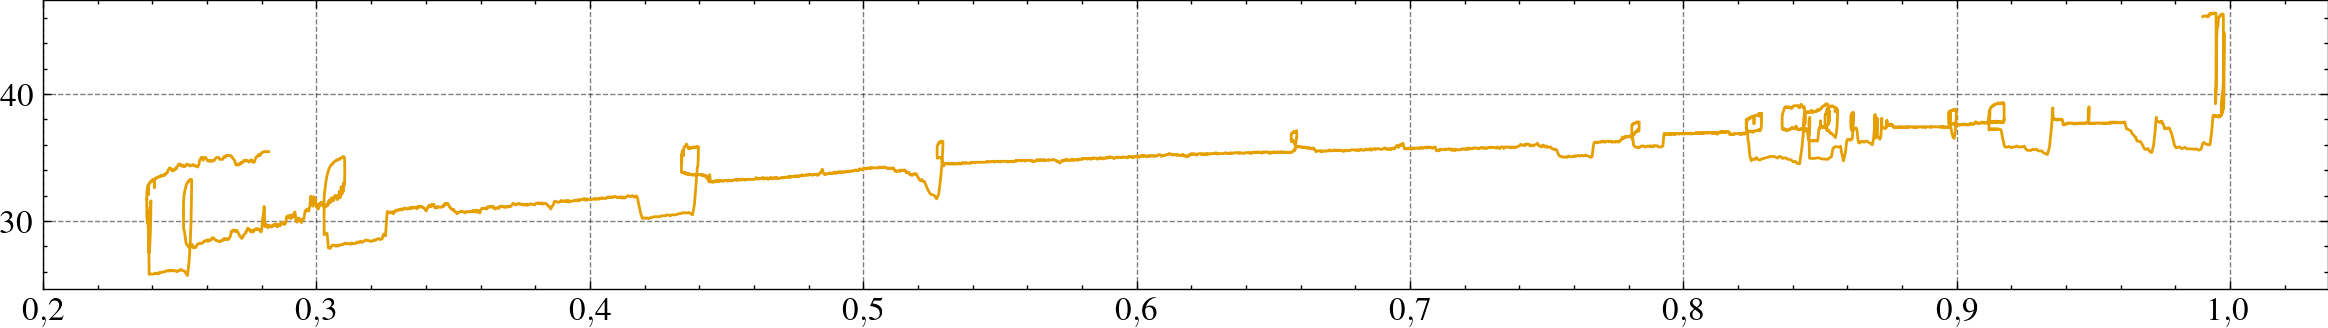

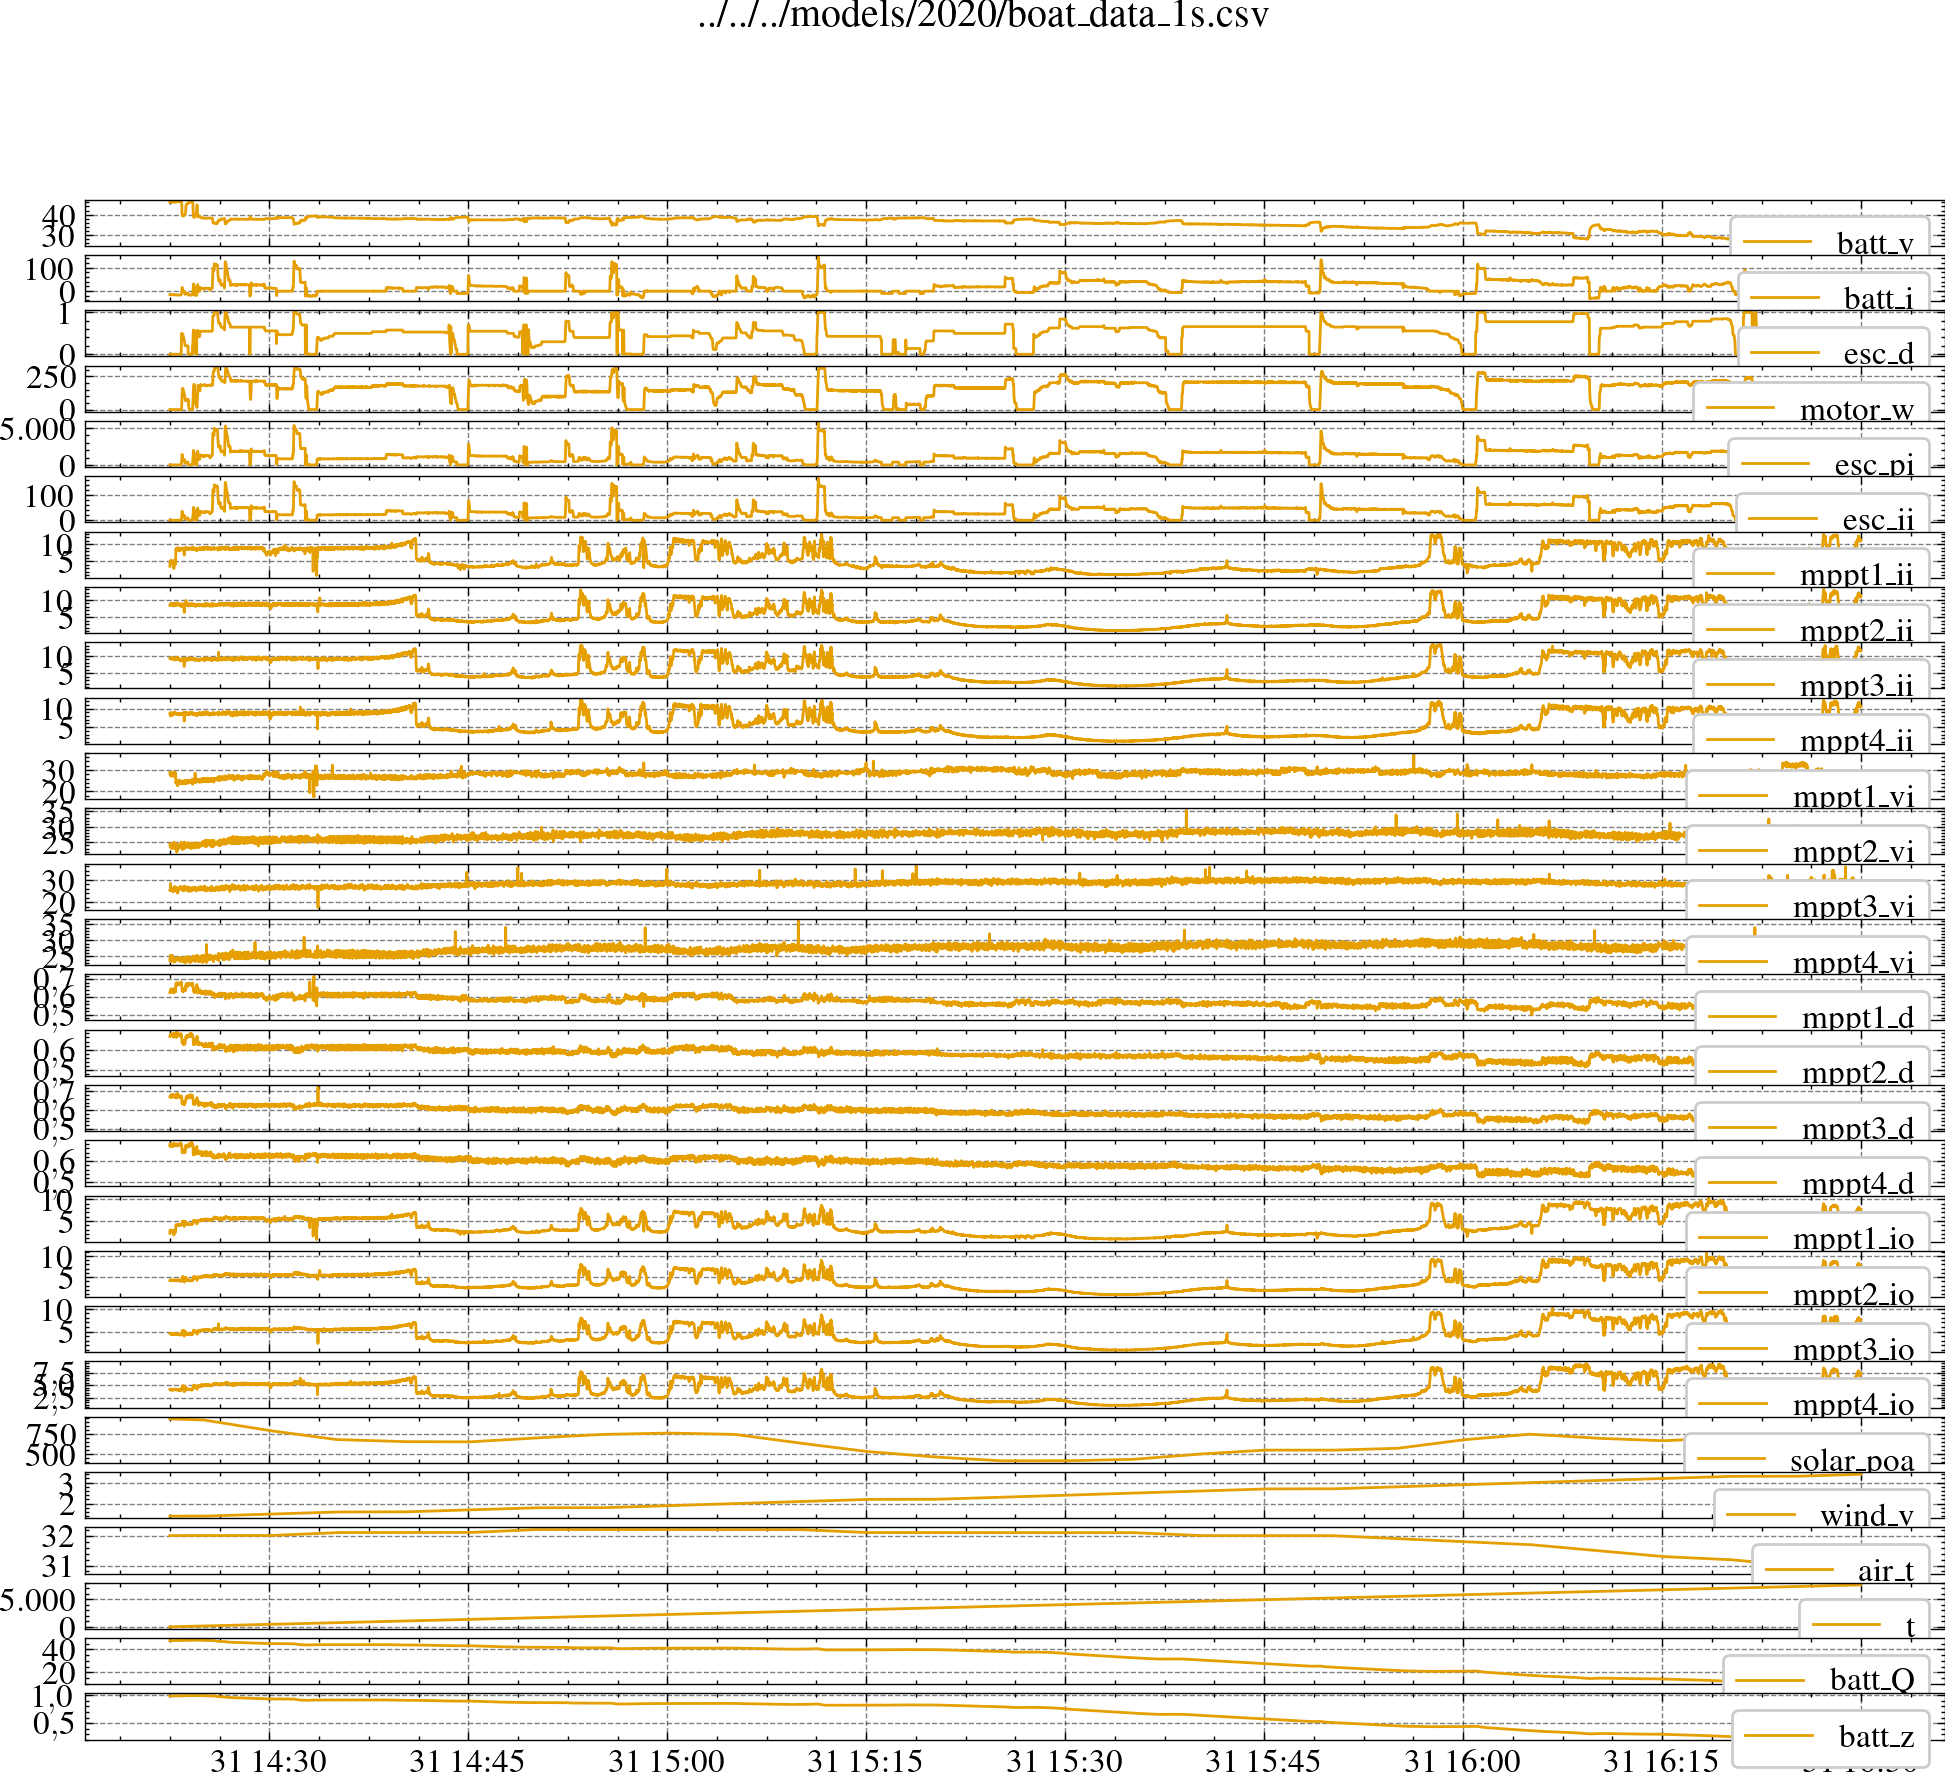

,batt_v,batt_i,esc_d,motor_w,esc_p_in,esc_i_in,mppt1_ii,mppt2_ii,mppt3_ii,mppt4_ii,...,mppt1_io,mppt2_io,mppt3_io,mppt4_io,solar_poa,wind_v,air_t,t,batt_Q,batt_z
count,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,...,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000,7650.000000
mean,35.764906,15.978011,0.486685,150.235382,1102.212827,31.897603,5.539496,5.728461,6.012656,5.656525,...,3.994260,4.141001,4.136382,3.940919,641.016070,2.364732,31.905866,3824.500000,32.025229,0.667192
std,2.999064,25.330869,0.260944,75.707258,828.571039,25.109951,3.202224,3.040051,3.188520,2.948573,...,2.239857,2.180055,2.154146,2.053935,123.254981,0.596596,0.357275,2208.509113,11.718049,0.244126
min,25.713988,-33.292683,0.000000,0.000000,0.000000,0.000000,0.897723,1.098891,1.213979,1.136713,...,0.753960,0.869441,0.918890,0.875336,419.001300,1.400000,30.800266,0.000000,11.420870,0.237935
25%,34.158172,0.000000,0.399902,130.825450,438.120201,11.907697,2.878789,3.178591,3.345719,3.149417,...,2.217917,2.460531,2.491489,2.365657,551.470995,1.800000,31.837549,1912.250000,20.911478,0.435656
50%,36.664177,13.699645,0.548828,175.929200,1058.620140,29.289830,4.326085,4.585191,4.810394,4.548935,...,3.250989,3.464948,3.464092,3.295402,672.645030,2.325033,32.062500,3824.500000,37.607053,0.783480
75%,37.868860,34.675675,0.658691,201.061940,1638.197925,47.400973,8.723885,8.672271,9.146377,8.659112,...,5.621594,5.603677,5.572673,5.318580,719.154025,2.862450,32.100000,5736.750000,41.388128,0.862253
max,46.376181,146.358300,1.000000,314.159270,5689.088736,164.851898,13.107605,13.138098,13.362953,12.387382,...,10.401903,10.699258,10.106625,9.418674,941.679900,3.399867,32.200000,7649.000000,47.894335,0.997799


nans:  0


,batt_v,batt_i,esc_d,motor_w,esc_p_in,esc_i_in,mppt1_ii,mppt2_ii,mppt3_ii,mppt4_ii,...,mppt1_io,mppt2_io,mppt3_io,mppt4_io,solar_poa,wind_v,air_t,t,batt_Q,batt_z
timestamp,,,,,,,,,,,,,,,,,,,,,
2020-01-31 14:22:30,46.106026,-14.931380,0.0,0.0,0.0,0.0,3.600327,8.439225,9.340786,8.695304,...,2.158262,4.261766,4.577136,4.159783,941.67990,1.400000,32.000000,0.0,47.520000,0.990000
2020-01-31 14:22:31,46.119329,-15.641843,0.0,0.0,0.0,0.0,4.883697,8.774137,9.345851,8.599902,...,2.859352,4.375686,4.519484,4.112824,941.60180,1.400000,32.000000,1.0,47.524246,0.990088
2020-01-31 14:22:32,46.093868,-15.167320,0.0,0.0,0.0,0.0,4.405498,8.796310,9.323546,8.039981,...,2.595787,4.314784,4.474259,4.008119,941.52370,1.400000,32.000000,2.0,47.528525,0.990178
2020-01-31 14:22:33,46.131479,-15.588507,0.0,0.0,0.0,0.0,5.095302,8.784903,9.136558,8.886777,...,2.873422,4.310630,4.484651,4.145246,941.44570,1.400000,32.000000,3.0,47.532797,0.990267
2020-01-31 14:22:34,46.150319,-15.645512,0.0,0.0,0.0,0.0,5.247149,8.918311,9.142964,8.670146,...,2.938104,4.269213,4.509043,4.154503,941.36755,1.400000,32.000000,4.0,47.537135,0.990357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-01-31 16:29:55,35.459708,-29.896963,0.0,0.0,0.0,0.0,11.159040,10.804716,11.787089,10.918976,...,7.627573,7.660729,7.625031,7.276921,639.87380,3.398533,30.802930,7645.0,13.527356,0.281820
2020-01-31 16:29:56,35.459708,-29.323760,0.0,0.0,0.0,0.0,10.936153,11.237955,11.508637,10.868303,...,7.593439,7.725141,7.389243,6.909226,639.60065,3.398867,30.802267,7646.0,13.535581,0.281991
2020-01-31 16:29:57,35.459708,-29.988852,0.0,0.0,0.0,0.0,11.525195,11.209108,11.802736,10.373062,...,7.652898,7.713610,7.603884,7.311750,639.32740,3.399200,30.801598,7647.0,13.543819,0.282163


In [ ]:
def compute_df_soc(df, nominal_Q, inplace=False):
    """
    Compute the State of Charge (SOC) of a battery.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        inplace (bool, optional): If True, the SOC values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed SOC values as a fraction of the nominal capacity.

    Notes:
        - The input DataFrame `df` is expected to contain a column named 'batt_Q' representing the battery charge.
        - The output SOC values are dimensionless fractions representing the battery's charge level relative to its nominal capacity.
        - If `inplace` is True, the computed SOC values are added as a new column 'batt_z' to the input DataFrame `df`.
    """
    SOC = df['batt_Q'].to_numpy() / nominal_Q

    if inplace:
        df['batt_z'] = SOC
    return SOC

def compute_df_capacity(df, nominal_Q, initial_SOC, inplace=False):
    """
    Compute the capacity of a battery based on cumulative integration of current over time.

    Parameters:
        df (pd.DataFrame): DataFrame containing battery data.
        nominal_Q (float): Nominal capacity of the battery in Ampere-hours (Ah).
        initial_SOC (float): Initial State of Charge (SOC) as a fraction of the nominal capacity.
        inplace (bool, optional): If True, the computed capacity values are added to the input DataFrame `df`.
                                  Default is False.

    Returns:
        np.ndarray: Array containing the computed capacity values in Ampere-hours (Ah).

    Notes:
        - The input DataFrame `df` is expected to contain columns 'batt_i' for battery current and 't' for time.
        - The output capacity values represent the remaining battery capacity after cumulative integration of current over time.
        - The input parameter `initial_SOC` is a dimensionless fraction representing the initial battery charge relative to its nominal capacity.
        - If `inplace` is True, the computed capacity values are added as a new column 'batt_Q' to the input DataFrame `df`.
    """
    from scipy.integrate import cumulative_trapezoid as cumtrapz

    time_hours = df['t'] / 3600.0  # Converts time in seconds to time in hours
    Q = (nominal_Q * initial_SOC) - cumtrapz(df['batt_i'], time_hours, initial=0)  # units: Amper-hour

    if inplace:
        df['batt_Q'] = Q
    return Q

def load_df(filename, start, end, nominal_Q, initial_SOC, resample_rule='1s', rename_columns={}):
    df = load_df_inner(filename, start, end, resample_rule, rename_columns)

    compute_df_capacity(df, nominal_Q, initial_SOC, inplace=True)
    compute_df_soc(df, nominal_Q, inplace=True)

    return df

# From Revezamento
tzinfo = timezone("America/Sao_Paulo")

start = pd.Timestamp(
    year=2020, month=1, day=31, hour=11, minute=22, second=30, tzinfo=tzinfo
).tz_convert(None)
end = pd.Timestamp(
    year=2020, month=1, day=31, hour=13, minute=30, second=0, tzinfo=tzinfo
).tz_convert(None)

filename = "../../../models/2020/boat_data_1s.csv"
rename_columns = {
    'Battery Pack Voltage': 'batt_v',
    'Battery Current': 'batt_i',
    'ESC Duty Cycle': 'esc_d',
    'Motor Angular Speed': 'motor_w',
    'ESC Input Power': 'esc_p_in',
    'ESC Input Current': 'esc_i_in',
    **{f'MPPT {i} Input Current': f'mppt{i}_i_in' for i in range(1,5)},
    **{f'MPPT {i} Input Voltage': f'mppt{i}_v_in' for i in range(1,5)},
    **{f'MPPT {i} Duty Cycle': f'mppt{i}_d' for i in range(1,5)},
    **{f'MPPT {i} Output Current': f'mppt{i}_i_out' for i in range(1,5)},
    'PVs G': 'pv_g',
    'Solar POA': 'solar_poa',
    'Wind Speed': 'wind_v',
    'Air Temperature': 'air_t',
}
df = load_df(filename, start, end, resample_rule='1s', rename_columns=rename_columns, nominal_Q=nominal_Q, initial_SOC=initial_SOC)

dfa = df.copy(deep=True)

plt.figure(figsize=(12, 2))
plt.plot(df['batt_z'], df['batt_v'])
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(len(df.columns), figsize=(12,10))
for k, col in enumerate(df.columns):
    ax[k].plot(df.index, df[col], label=col)
    ax[k].legend(loc=1)

plt.suptitle(filename)
plt.tight_layout()
plt.show()

display(df.describe())

# Check for nans in the data
print('nans: ', df.isna().sum().sum())

df

# Battery Equivalent Circuit Model


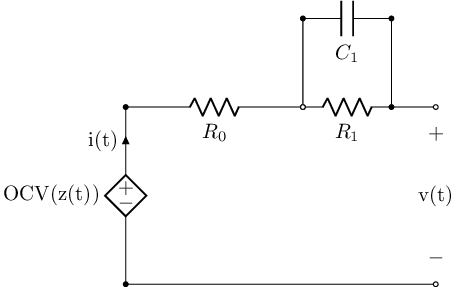

In [21]:
# !pip install lcapy zfitpy pyspice
# %pip install https://github.com/mph-/lcapy/archive/master.zip
# Open `tllocalmgr`, then `install circuitikz`, then `exit`, then `sudo texhash`
import lcapy as lca

circuit_draw_params = dict(
    # help_lines=1,
    # debug=True,
    draw_nodes=True,
    label_nodes=False,
    label_ids=True,
    label_values=False,
    cpt_size=1,
    node_spacing=3,
    scale=1,
    dpi=150,
)

circuit = lca.Circuit("""
E1 R0.1 0 2 0; down, l={OCV(z(t))}, i>={i(t)}
R0 .1 .2; right
R1 R0.2 .2; right=0.5
C1 .1 .2; right=0.5
W R1.1 C1.1; up=0.5
W R1.2 C1.2; up=0.5
W R1.2 P1.1; right=0.25
P1 .1 0_2; down, v={v(t)}
W 0 0_2; right
;""")
circuit.draw(**circuit_draw_params)
circuit.draw(**circuit_draw_params, filename="/home/joaoantoniocardoso/workspace_TCC/repo/tcc/imgs/battery_model.png")


![](feZkCLr.png)

De acordo com [Gregory L. Plett](https://books.google.com.br/books?id=suLRCgAAQBAJ&pg=PA29&hl=pt-BR&source=gbs_toc_r&cad=2#v=onepage&q&f=false), as seguintes equações representam o sistema da imagem acima, onde $z(t)$ é o estado de carga da bateria:

$$ \begin{aligned}
    \frac{di_{R_{1}}(t)}{dt} &= 
        -\frac{1}{R_{1} C_{1}} i_{R_{1}}(t) 
        +\frac{1}{R_{1} C_{1}} i(t) \\
    v(t) &= 
        -R_{1} i_{R_{1}}(t) 
        -R_{0} i(t) 
        +OCV(z(t)) 
\end{aligned} $$

O estado de carga ($z(t)$) pode ser definido como nas equações abaixo, onde $Q$ é a carga nominal da bateria, e $\eta$, a eficiência culombica:

$$ \begin{aligned}
    z(t) &= 
        z(t_{0}) 
        -\frac{1}{Q} \int_{t_{0}}^t \eta(t) i(t) dt \\
    \frac{dz(t)}{dt} &= 
        -\frac{\eta(t) i(t)}{Q}
\end{aligned} $$

Para que possam ser utilizadas os métodos de solução de sistemas no espaço de estados, podemos separar $VOC(z(t))$ em um modelo externo, considerando-o como uma entrada, deste modo, a função $VOC(z(t))$ pode ser um modelo caixa-preta.

In [15]:
import control as ct
from math import sqrt, pi

class SolarBoat:
    @classmethod
    def _update(cls, t, x, u, params: dict):
        # Params
        batt_eta, batt_Q, batt_R_1, batt_C_1, motor_R_A, motor_L_A, motor_B, motor_I_r, motor_I_r_load, motor_K_Q = (
            params['batt_eta'],
            params['batt_Q'],
            params['batt_R_1'],
            params['batt_C_1'],
            params['motor_R_A'],
            params['motor_L_A'],
            params['motor_B'],
            params['motor_I_r'],
            params['motor_I_r_load'],
            params['motor_K_Q'],
        )

        # States
        batt_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        # batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Outputs
        y = cls._outputs(t, x, u, params)
        batt_i = y[2]
        motor_w = y[6]
        motor_v = y[7]
        motor_Q = y[8]

        # System of differential equations
        d_batt_i_R1 = (batt_i - batt_i_R1)/(batt_C_1*batt_R_1)
        d_batt_z = -batt_eta*batt_i/batt_Q
        d_motor_i = (-motor_K_Q*motor_w - motor_R_A*motor_i + motor_v)/motor_L_A
        d_motor_w = (-motor_B*motor_w + motor_K_Q*motor_i - motor_Q)/(motor_I_r + motor_I_r_load)

        return np.array([d_batt_i_R1, d_batt_z, d_motor_i, d_motor_w])

    @classmethod
    def _outputs(cls, t, x, u, params: dict):
        # Params
        pv_S, pv_eta, mppt_eta, mppts_n, batt_R_0, batt_R_1, batt_k_V_OC_coeffs, prop_K_Q, prop_D, rho_water, trans_eta, esc_eta, trans_K, others_pi = (
            params['pv_S'],
            params['pv_eta'],
            params['mppt_eta'],
            params['mppts_n'],
            params['batt_R_0'],
            params['batt_R_1'],
            params['batt_k_V_OC_coeffs'],
            params['prop_K_Q'],
            params['prop_D'],
            params['rho_water'],
            params['trans_eta'],
            params['esc_eta'],
            params['trans_k'],
            params['others_pi'],
        )

        # Inputs
        pv_g = u[0]  # Total incident irradiance [W/m^2]
        esc_D = u[1]  # ESC duty-cycle

        # States
        batt_i_R1 = x[0]  # battery current flowing through the internal serie-parallel resistance [A]
        batt_z = x[1]  # battery State Of Charge [unitless]
        motor_i = x[2]  # Motor current [A]
        motor_w = x[3]  # Motor angular speed [rad/s]

        # Output equations
        esc_i_in = esc_D*motor_i/esc_eta
        batt_ocv = np.polynomial.Polynomial(batt_k_V_OC_coeffs)(batt_z)
        batt_v = -batt_R_0*esc_i_in/2 - batt_R_1*batt_i_R1/2 + batt_ocv/2 + sqrt(4*batt_R_0*mppt_eta*mppts_n*pv_g*pv_S*pv_eta - 4*batt_R_0*others_pi + (batt_R_0*esc_i_in + batt_R_1*batt_i_R1 - batt_ocv)**2)/2
        others_ii = others_pi/batt_v
        motor_v = batt_v*esc_D
        mppts_i_out = mppt_eta*mppts_n*pv_g*pv_S*pv_eta/batt_v
        batt_i = esc_i_in - mppts_i_out + others_ii
        motor_Q = motor_w**2*prop_D**5*prop_K_Q*rho_water*trans_K**3/trans_eta

        return np.array([batt_v, batt_z, batt_i, mppts_i_out, others_ii, esc_i_in, motor_w, motor_v, motor_Q])


    @classmethod
    def build(cls, params: dict):
        return ct.NonlinearIOSystem(
            cls._update,
            cls._outputs,
            name='solar_boat',
            states=('batt_i_R1', 'batt_z', 'motor_i', 'motor_w'),
            inputs=('pv_g', 'esc_D'),
            outputs=('batt_v', 'batt_z', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_i_in', 'motor_w', 'motor_v', 'motor_Q'),
            params=params,
        )

SolarBoat.build({})

<NonlinearIOSystem:solar_boat:['pv_g', 'esc_D']->['batt_v', 'batt_z', 'batt_i', 'mppts_i_out', 'others_ii', 'esc_i_in', 'motor_w', 'motor_v', 'motor_Q']>

In [16]:
batt_name = 'D35'
cell_amps_hour = 48
series_cells = 3
parallel_cells = 1
cell_voltage = 12
nominal_Q = parallel_cells * cell_amps_hour  # Capacity, in Amper-hour
initial_SOC = 0.99
nominal_E = series_cells * parallel_cells * cell_amps_hour * cell_voltage

propulsion_params = {
    'motor_R_A': 0.01900855299492548,
    'motor_L_A': 6.759203032015685e-05,
    'motor_B': 0.015512840581313322,
    'motor_I_r': 0.011255783139838839,
    'motor_K_Q': 0.10459081137088254,
    'motor_I_r_load': 0.007265306483689661,
    'prop_K_Q': 0.00018534573532427725,
    'prop_D': 0.2667,
    'rho_water': 1023,
    'trans_eta': 0.9,
    'esc_eta': 0.8660,
    'trans_k': 14/22,
}

generation_params = {
    'pv_S': 1.650 * 0.992,
    'pv_eta': 0.1589,
    'mppt_eta': 0.9259,
    'mppts_n': 4,
}

battery_params = {
    'batt_eta': 1,
    'batt_Q': cell_amps_hour * 3600,
    'batt_R_0': 0.05,
    'batt_R_1': 0.01,
    'batt_C_1': 25,
    'batt_k_V_OC_coeffs': [25.4633167882052, 37.126691660372906, -21.115645449324788, -30.02431761749073, 29.382700604694268],
}

others_params = {
    'others_pi': 20 * 0.52,
}

solar_boat_params = generation_params | battery_params | propulsion_params | others_params
solar_boat_params

{'pv_S': 1.6367999999999998,
 'pv_eta': 0.1589,
 'mppt_eta': 0.9259,
 'mppts_n': 4,
 'batt_eta': 1,
 'batt_Q': 172800,
 'batt_R_0': 0.05,
 'batt_R_1': 0.01,
 'batt_C_1': 25,
 'batt_k_V_OC_coeffs': [25.4633167882052,
  37.126691660372906,
  -21.115645449324788,
  -30.02431761749073,
  29.382700604694268],
 'motor_R_A': 0.01900855299492548,
 'motor_L_A': 6.759203032015685e-05,
 'motor_B': 0.015512840581313322,
 'motor_I_r': 0.011255783139838839,
 'motor_K_Q': 0.10459081137088254,
 'motor_I_r_load': 0.007265306483689661,
 'prop_K_Q': 0.00018534573532427725,
 'prop_D': 0.2667,
 'rho_water': 1023,
 'trans_eta': 0.9,
 'esc_eta': 0.866,
 'trans_k': 0.6363636363636364,
 'others_pi': 10.4}

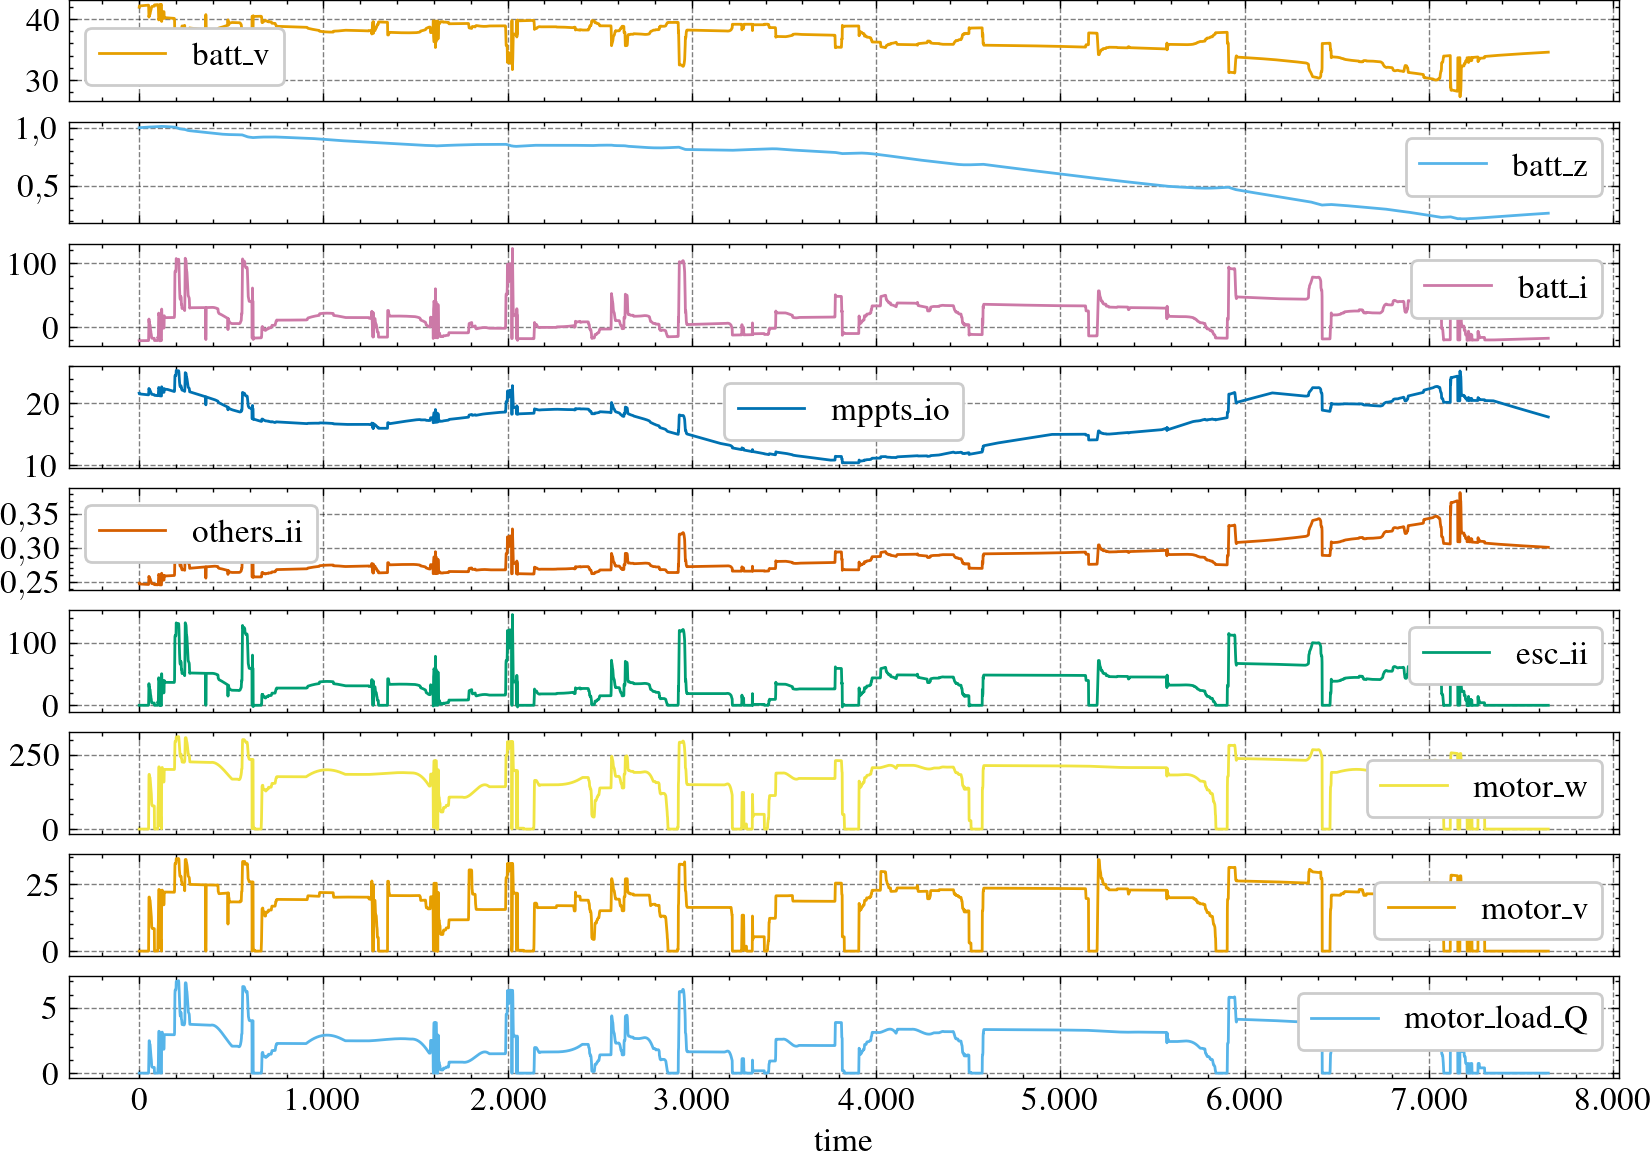

In [17]:
# Time array
T = df['t'].to_numpy()

# Inputs
U = df[['solar_poa', 'esc_d']].to_numpy().T

# Model
solar_boat = SolarBoat.build(solar_boat_params)

# Initial state
X0 = np.zeros(solar_boat.nstates)
X0[solar_boat.state_index['batt_z']] = 1

# Simulation
res = ct.input_output_response(solar_boat, T=T, U=U, X0=X0, solve_ivp_method='Radau')
ydata = res.to_pandas().set_index('time')[res.output_labels]

ydata.plot(subplots=True, figsize=(10,7));

# Optimization

In [18]:
from sklearn.preprocessing import RobustScaler
from pymoo.optimize import minimize
from pymoo.algorithms.soo.nonconvex.nelder import NelderMead
from pymoo.algorithms.soo.nonconvex.pso import PSO
from pymoo.algorithms.soo.nonconvex.isres import ISRES
from pymoo.algorithms.soo.nonconvex.es import ES
from pymoo.algorithms.soo.nonconvex.de import DE
from pymoo.algorithms.soo.nonconvex.g3pcx import G3PCX
from pymoo.algorithms.soo.nonconvex.pattern import PatternSearch
from pymoo.operators.sampling.lhs import LHS
from pymoo.termination.default import DefaultSingleObjectiveTermination
from pymoo.parallelization.starmap import StarmapParallelization
from multiprocessing.pool import ThreadPool
from multiprocessing import Pool

import warnings
warnings.filterwarnings("ignore")

def model_function(T, U, X0, **params):
    return ct.input_output_response(
        SolarBoat.build(params=params),
        T=T,
        U=U,
        X0=X0,
        solve_ivp_method='Radau',
    ).to_pandas()

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |       80 |  3.500000E+08 |  2.0917754834
     2 |      160 |  8.750003E+07 |  1.6253748691
     3 |      240 |  3.750001E+07 |  1.6253748691
     4 |      320 |  4.7577228258 |  1.3002160411
     5 |      400 |  3.0157630083 |  1.3002160411
     6 |      480 |  2.4413056343 |  0.9869491273
     7 |      560 |  2.1501523224 |  0.9869491273
     8 |      640 |  1.9551222583 |  0.8171458097
     9 |      720 |  1.7264774985 |  0.6839912850
    10 |      800 |  1.5892320165 |  0.6839912850
    11 |      880 |  1.4086492529 |  0.4800173979
    12 |      960 |  1.2683890684 |  0.4800173979
    13 |     1040 |  1.1551214604 |  0.4800173979
    14 |     1120 |  1.0350162446 |  0.4391082240
    15 |     1200 |  0.8912656827 |  0.4391082240
    16 |     1280 |  0.7770475881 |  0.4291918257
    17 |     1360 |  0.6993332612 |  0.2870303978
    18 |     1440 |  0.6500799299 |  0.2600526325
    19 |     1520 |  0.6022479871 |  0.1539712323


{'batt_R_0': 0.05,
 'batt_R_1': 0.01,
 'batt_C_1': 25,
 'batt_k_V_OC_coeffs': [25.4633167882052,
  37.126691660372906,
  -21.115645449324788,
  -30.02431761749073,
  29.382700604694268]}

Best parameters found:


{'batt_R_0': 0.029599799280574747,
 'batt_R_1': 0.030581152451663967,
 'batt_C_1': 957.8895197461286,
 'batt_k_V_OC_coeffs': [28.28191619655402,
  16.805691207235753,
  -11.008886964595442,
  7.6254863399321975,
  -1.1289723762167452]}

Objective value at solution: [0.02833548]


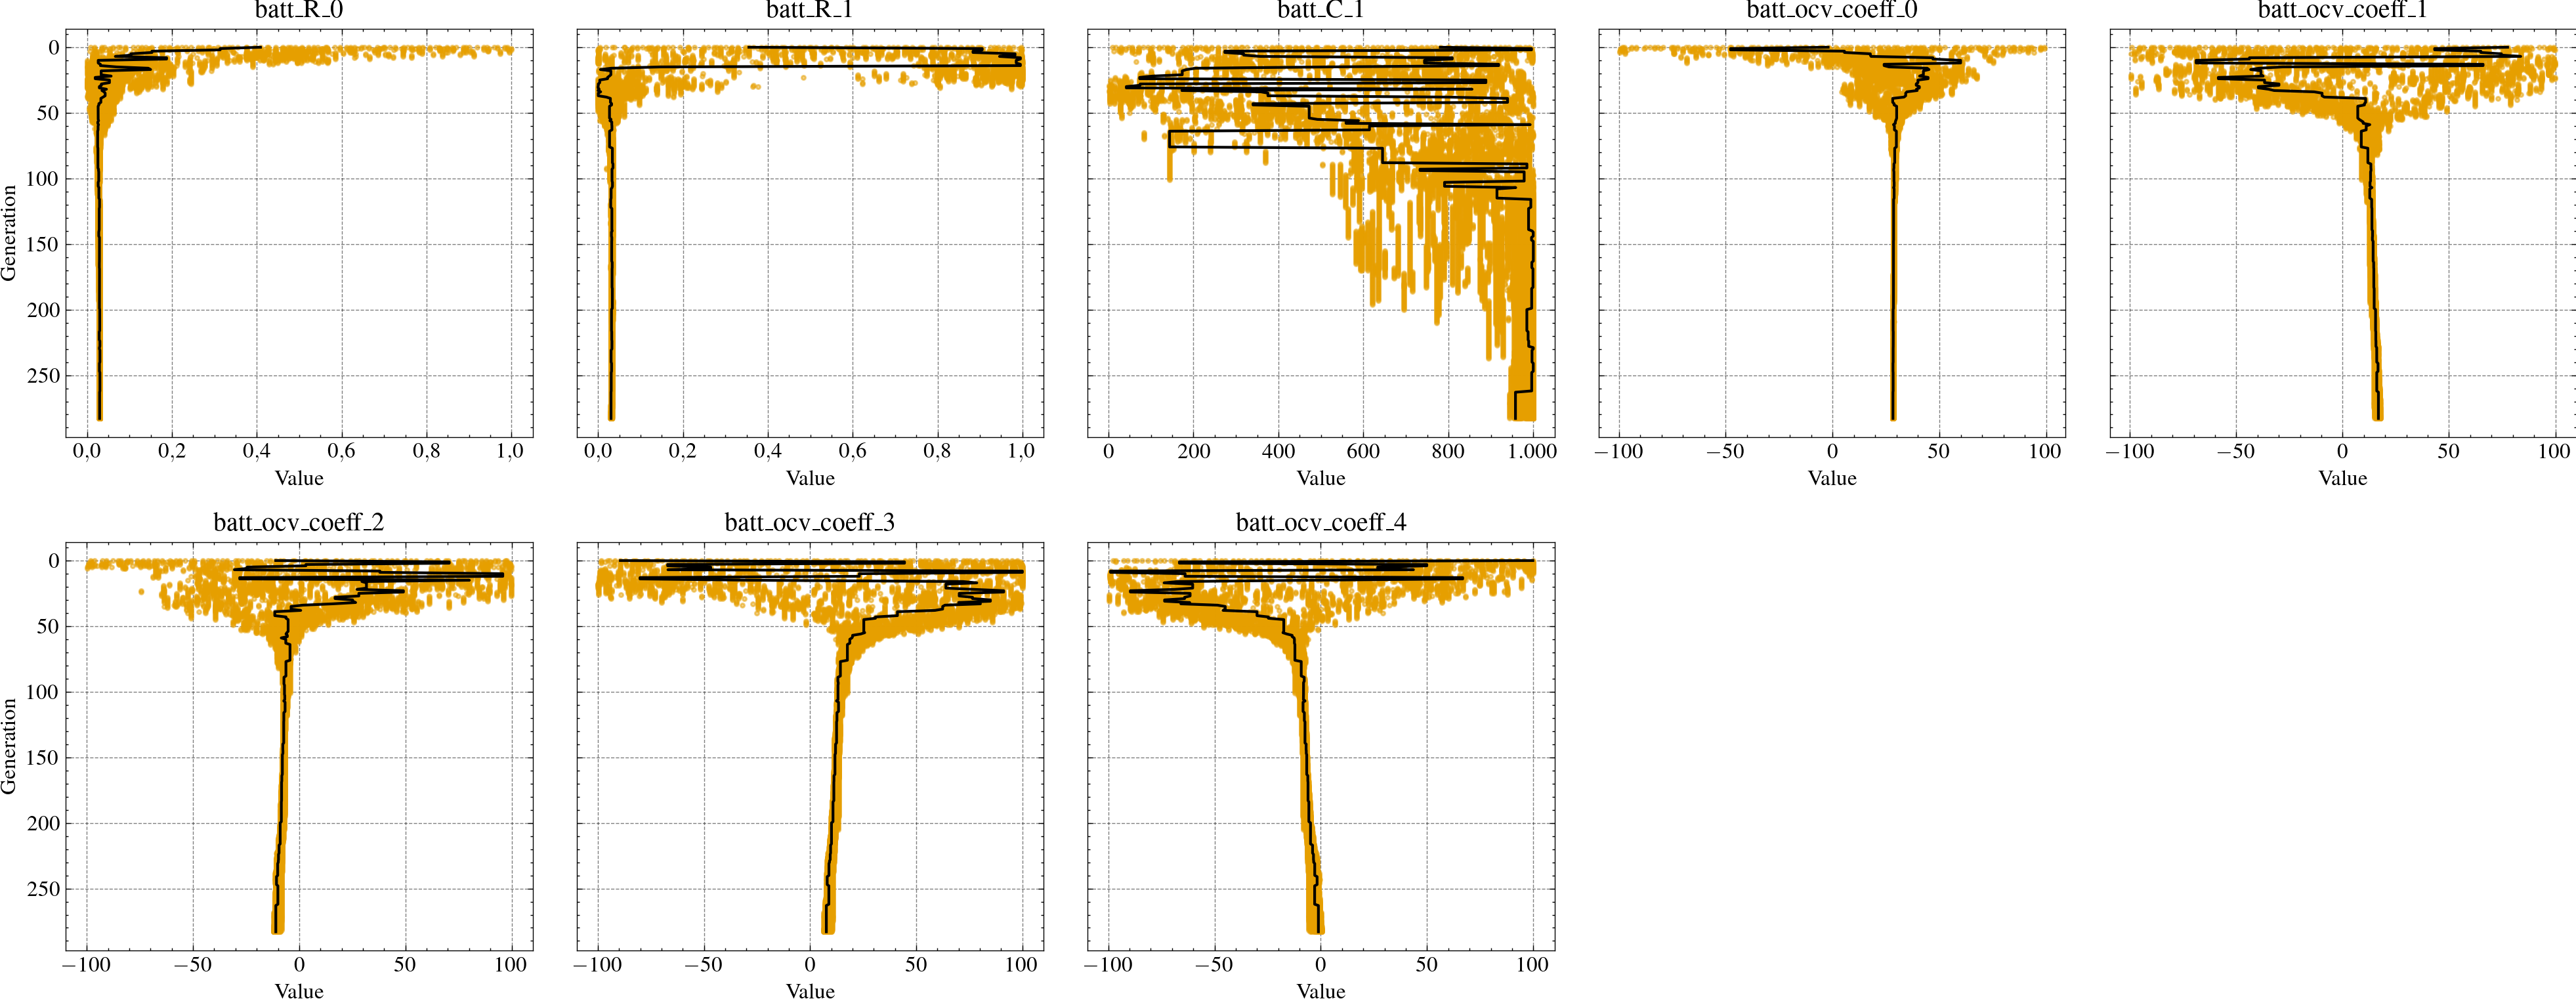

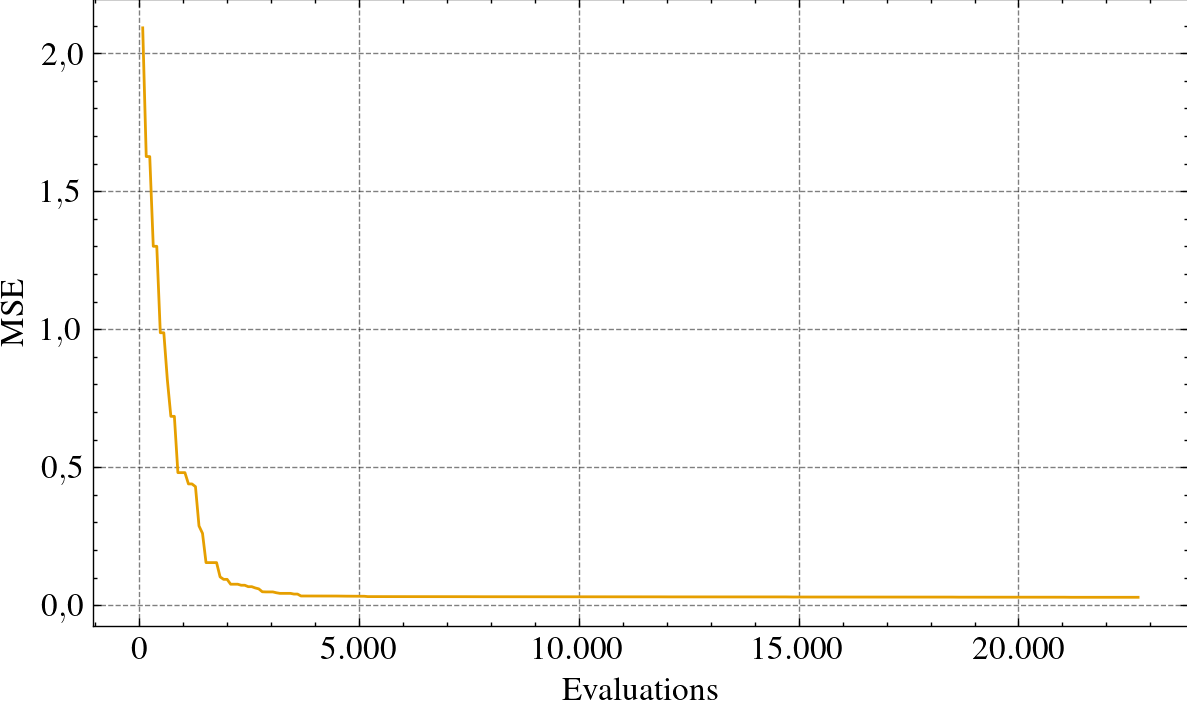

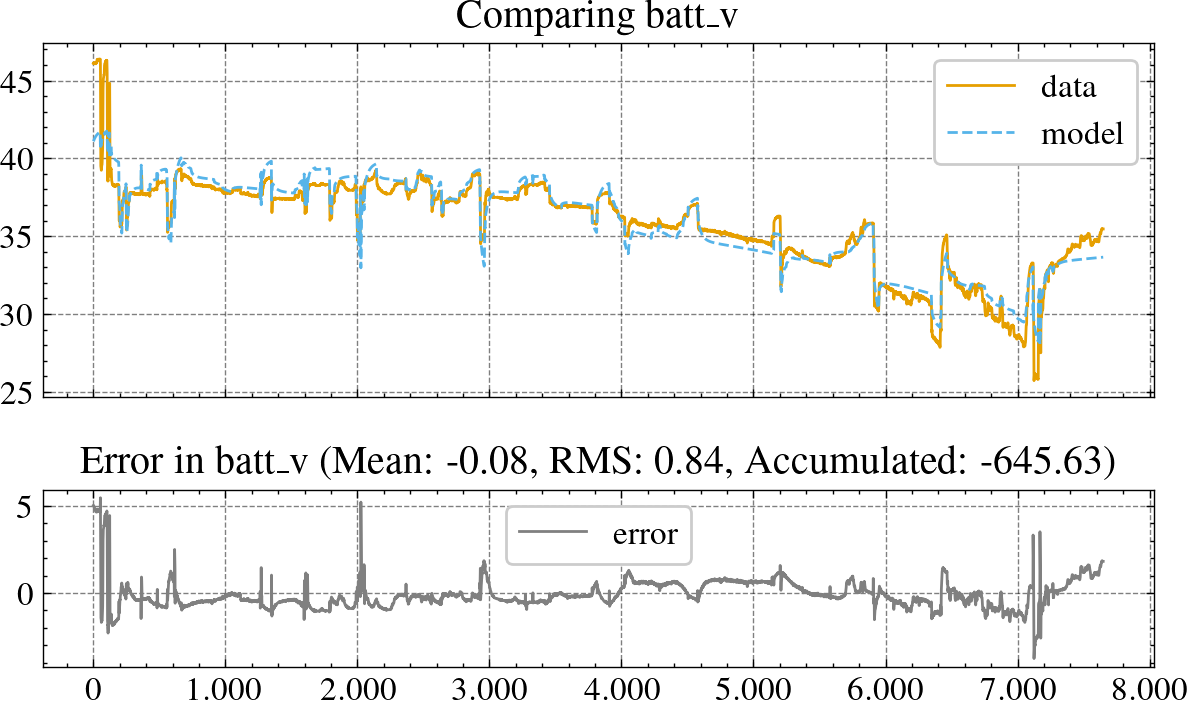

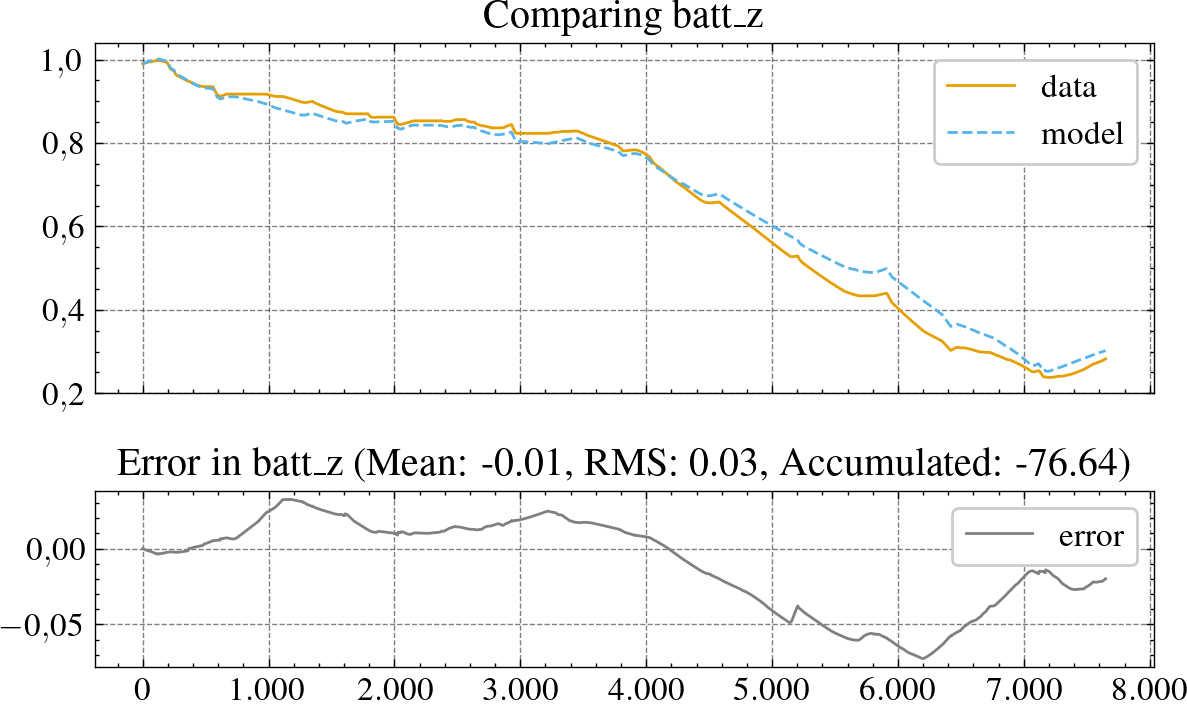

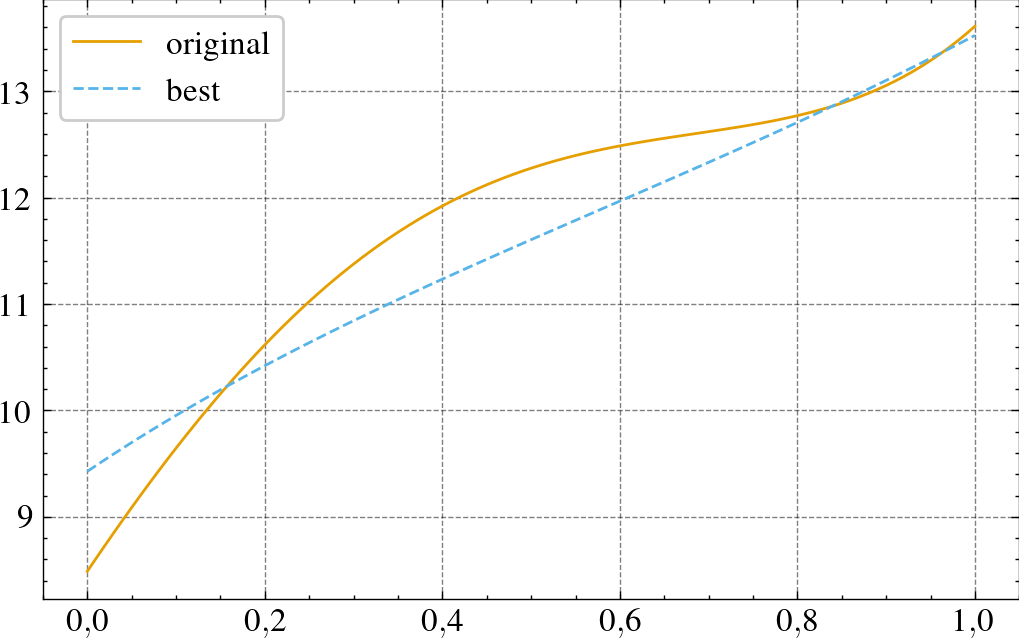

CPU times: user 37.2 s, sys: 6.74 s, total: 44 s
Wall time: 6h 45min 17s


In [ ]:
%%time
## BATTERY OPTIMIZATION

# Select the optimization data
data_cols = ['batt_v', 'batt_z']
input_cols = ['solar_poa', 'esc_d']

# Put simulation data into df
df_train = dfa.copy(deep=True)[data_cols + input_cols]

# Set model states initial conditions
X0_dict = {'batt_z': df_train['batt_z'][0]}

# Initialize Parameters
params_bounds = {
    'batt_R_0': dict(min=1e-6, max=1),
    'batt_R_1': dict(min=1e-6, max=1),
    'batt_C_1': dict(min=1, max=1e3),
}
n_coeffs = 5
for i in range(0, n_coeffs):
    params_bounds[f'batt_ocv_coeff_{i}'] = dict(min=-100, max=100)

# Initialize the thread pool and create the runner
n_processes = 32
pool = Pool(processes=n_processes)
runner = StarmapParallelization(pool.starmap)

# Initialize the problem
model = SolarBoat
model_params = solar_boat_params
problem = MyOptimizationProblem(
    model=model,
    model_function=model_function,
    training_data=df_train,
    training_data_columns=data_cols,
    model_params=model_params,
    opt_params_bounds=params_bounds,
    input_initial_state=input_initial_state,
    input_columns=input_cols,
    data_scaler=RobustScaler,
    elementwise_runner=runner,
)

# algorithm = ISRES(n_offsprings=1000, rule=1.0 / 7.0, gamma=0.85, alpha=0.2)
algorithm = DE(
    pop_size=10*len(params_bounds),
    sampling=LHS(),
    variant="DE/rand/1/bin",
    F=0.2,
    CR=0.9,
)

# Specify termination criteria (optional)
termination = DefaultSingleObjectiveTermination(
    xtol=1e-8,
    cvtol=1e-6,
    ftol=1e-6,
    period=20,
    n_max_gen=1000,
    n_max_evals=100000
)

# Run the optimization
result = minimize(
    problem,
    algorithm,
    termination=termination,
    seed=42,
    verbose=True,
    save_history=True,
)
print('Threads:', result.exec_time)
pool.close()
pool.join()

# Print the results
best_params = convert_to_model_params({k: result.X[i] for (i, k) in enumerate(params_bounds.keys())})
original_params = {k: convert_to_model_params(model_params)[k] for k in best_params.keys()}
print("Original parameters were:")
display(original_params)
print("Best parameters found:")
display(best_params)
print("Objective value at solution:", result.F)

plot_optimization_params(result, params_bounds)
plot_optimization_error(result, params_bounds)

model_tmp = model.build({})
X0 = np.zeros(model_tmp.nstates)
for key, value in X0_dict.items():
    X0[model_tmp.state_index[key]] = value
best_fit_data = model_function(T, U, X0, **(model_params | best_params))

for col in data_cols:
    plot_compare(df, best_fit_data, col)

soc_test = np.linspace(0, 1, 101, endpoint=True)
plt.plot(soc_test, np.polynomial.Polynomial(original_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='original')
plt.plot(soc_test, np.polynomial.Polynomial(best_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='best')
plt.legend()
plt.show()

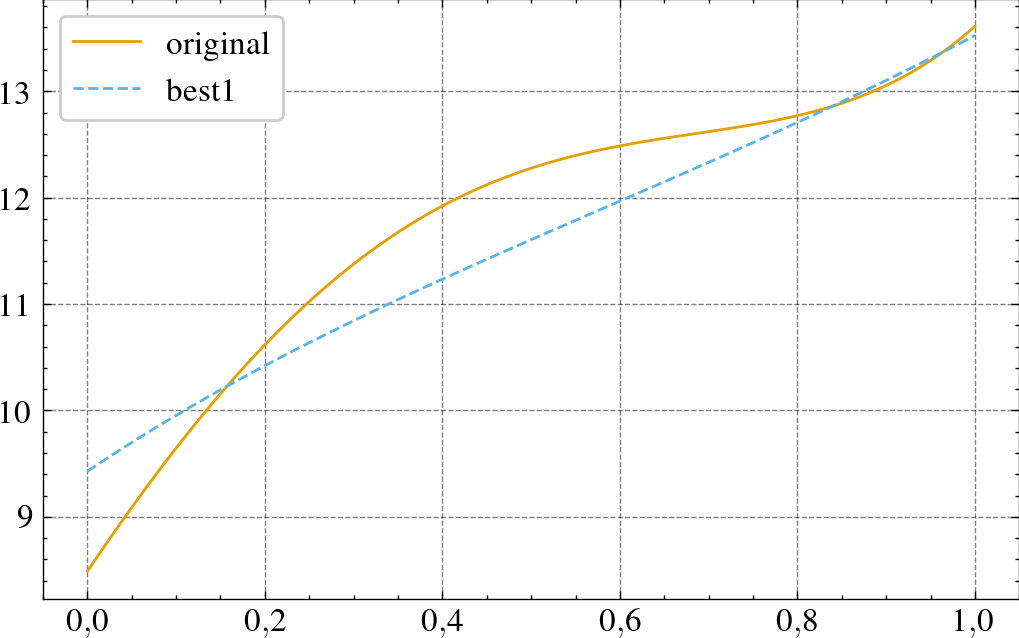

In [20]:
soc_test = np.linspace(0, 1, 101, endpoint=True)
plt.plot(soc_test, np.polynomial.Polynomial(original_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='original')
plt.plot(soc_test, np.polynomial.Polynomial(best_params['batt_k_V_OC_coeffs'])(soc_test)/3, label='best1')
plt.legend()